# 📊 Notebook 3: New Items Health Analysis

## 🎯 Purpose
Evaluate new items (< 90 days) performance, identify health risks, and provide actionable recommendations.

## 📥 Input
- **File**: `dbscan_classification.pkl` (from Notebook 2)
- **Filter**: `classification == 'NEW_ITEM'`

## 📤 Output
- **File**: `new_items_health_report.csv` ⭐ (Complete health analysis)
- **File**: `new_items_health_report.pkl` (Faster loading)
- **File**: `new_items_at_risk.csv` (HIGH and MEDIUM risk items)
- **File**: `new_items_healthy.csv` (HEALTHY performing items)
- **File**: `new_items_critical.csv` (CRITICAL items needing immediate action)
- **File**: `new_items_summary.csv` (Executive summary)
- **File**: `new_items_health_dashboard.png` (Visualizations)

## 🏥 Health Assessment Framework

### Health Score (0-100):
```python
health_score = (
    sales_performance * 0.40 +      # Meeting sales targets
    customer_acquisition * 0.30 +   # Building customer base
    stock_adequacy * 0.20 +         # Right inventory level
    growth_trend * 0.10             # Improving over time
)
```

### Risk Categories:
- **HEALTHY** (80-100): Meeting/exceeding targets
- **AT_RISK** (50-79): Below expectations, needs attention
- **CRITICAL** (0-49): Failing, immediate action required

### Life Stages:
- **LAUNCH** (0-30 days): Initial introduction
- **LEARNING** (31-60 days): First performance data
- **GRADUATION** (61-90 days): Ready for standard treatment

In [1]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1️⃣ Load Classified Data

In [2]:
# Load classified data from Notebook 2
try:
    print("⏳ Loading classified data from pickle...")
    df = pd.read_pickle('/tmp/dbscan_classification.pkl')
    print("✅ Loaded from pickle")
except FileNotFoundError:
    print("⏳ Pickle not found, loading from CSV...")
    df = pd.read_csv('/tmp/dbscan_classification.csv')
    print("✅ Loaded from CSV")

print(f"\n📊 Total items in dataset: {len(df):,}")

# Filter NEW_ITEM only
new_items = df[df['classification'] == 'NEW_ITEM'].copy()

print(f"\n🆕 NEW ITEMS Found: {len(new_items):,}")

if len(new_items) == 0:
    print("\n⚠️ No new items found in the dataset!")
    print("   This could mean:")
    print("   1. All items are older than 90 days")
    print("   2. Classification needs to be re-run")
    print("\n   Exiting analysis...")
else:
    print(f"   Stock Value: ₹{new_items['stock_value'].sum():,.0f}")
    print(f"   Avg Age: {new_items['days_since_creation'].mean():.1f} days")
    print(f"   Avg Velocity: {new_items['velocity_90d'].mean():.3f} units/day")

⏳ Loading classified data from pickle...
✅ Loaded from pickle

📊 Total items in dataset: 13,489

🆕 NEW ITEMS Found: 333
   Stock Value: ₹64,672
   Avg Age: 108.2 days
   Avg Velocity: 0.017 units/day


## 2️⃣ Determine Life Stage

### Stages based on age:
- **LAUNCH** (0-30 days): Just introduced
- **LEARNING** (31-60 days): Building history
- **GRADUATION** (61-90 days): Ready to graduate

In [3]:
if len(new_items) > 0:
    def get_life_stage(days_since_first_activity):
        """
        Determine new item life stage
        """
        if days_since_first_activity <= 30:
            return 'LAUNCH'
        elif days_since_first_activity <= 60:
            return 'LEARNING'
        else:
            return 'GRADUATION'
    
    new_items['life_stage'] = new_items['days_since_first_activity'].apply(get_life_stage)
    new_items['days_in_stage'] = new_items['days_since_first_activity']
    
    print("\n📊 LIFE STAGE DISTRIBUTION:\n")
    print(new_items['life_stage'].value_counts())
    print()
    
    for stage in ['LAUNCH', 'LEARNING', 'GRADUATION']:
        subset = new_items[new_items['life_stage'] == stage]
        if len(subset) > 0:
            print(f"{stage:12s}: {len(subset):3d} items - Avg age: {subset['days_since_first_activity'].mean():.1f} days")


📊 LIFE STAGE DISTRIBUTION:

life_stage
GRADUATION    196
LAUNCH         71
LEARNING       66
Name: count, dtype: int64

LAUNCH      :  71 items - Avg age: 26.7 days
LEARNING    :  66 items - Avg age: 45.6 days
GRADUATION  : 196 items - Avg age: 74.1 days


## 3️⃣ Calculate Sales Performance Score (40%)

### Scoring Logic:
- **Excellent (90-100)**: > 3 units/day
- **Good (70-89)**: 2-3 units/day (B2B target)
- **Fair (50-69)**: 1-2 units/day
- **Poor (30-49)**: 0.5-1 units/day
- **Failing (0-29)**: < 0.5 units/day

In [4]:
if len(new_items) > 0:
    def calculate_sales_performance(row):
        """
        Score sales performance (0-100)
        Based on daily sales rate
        """
        # Calculate daily sales rate
        days_active = max(row['days_since_first_activity'], 1)
        daily_rate = row['total_qty_sold'] / days_active
        
        # Score based on B2B targets (2-3 units/day is good)
        if daily_rate >= 3.0:
            score = 100
        elif daily_rate >= 2.0:
            score = 70 + (daily_rate - 2.0) * 30  # 70-100
        elif daily_rate >= 1.0:
            score = 50 + (daily_rate - 1.0) * 20  # 50-70
        elif daily_rate >= 0.5:
            score = 30 + (daily_rate - 0.5) * 40  # 30-50
        else:
            score = daily_rate * 60  # 0-30
        
        return min(100, max(0, score)), daily_rate
    
    # Apply calculation
    new_items[['sales_performance_score', 'daily_sales_rate']] = new_items.apply(
        calculate_sales_performance, axis=1, result_type='expand'
    )
    
    print("\n✅ Sales Performance Score calculated")
    print(f"\n📊 Sales Performance Distribution:")
    print(f"   Mean: {new_items['sales_performance_score'].mean():.1f}")
    print(f"   Median: {new_items['sales_performance_score'].median():.1f}")
    print(f"   Min: {new_items['sales_performance_score'].min():.1f}")
    print(f"   Max: {new_items['sales_performance_score'].max():.1f}")


✅ Sales Performance Score calculated

📊 Sales Performance Distribution:
   Mean: 1.9
   Median: 0.7
   Min: 0.0
   Max: 36.7


## 4️⃣ Calculate Customer Acquisition Score (30%)

### Scoring Logic:
- **Excellent (90-100)**: 10+ unique customers
- **Good (70-89)**: 5-9 customers
- **Fair (50-69)**: 3-4 customers
- **Poor (30-49)**: 1-2 customers
- **Failing (0-29)**: 0 customers

In [5]:
if len(new_items) > 0:
    def calculate_customer_acquisition(row):
        """
        Score customer acquisition (0-100)
        Based on unique customer count
        """
        customers = row['unique_customers']
        
        if customers >= 10:
            score = 100
        elif customers >= 5:
            score = 70 + (customers - 5) * 6  # 70-100
        elif customers >= 3:
            score = 50 + (customers - 3) * 10  # 50-70
        elif customers >= 1:
            score = 30 + (customers - 1) * 10  # 30-50
        else:
            score = 0
        
        return min(100, score)
    
    new_items['customer_acquisition_score'] = new_items.apply(
        calculate_customer_acquisition, axis=1
    )
    
    print("\n✅ Customer Acquisition Score calculated")
    print(f"\n📊 Customer Acquisition Distribution:")
    print(f"   Mean: {new_items['customer_acquisition_score'].mean():.1f}")
    print(f"   Items with 0 customers: {(new_items['unique_customers'] == 0).sum()}")
    print(f"   Items with 5+ customers: {(new_items['unique_customers'] >= 5).sum()}")


✅ Customer Acquisition Score calculated

📊 Customer Acquisition Distribution:
   Mean: 16.2
   Items with 0 customers: 154
   Items with 5+ customers: 0


## 5️⃣ Calculate Stock Adequacy Score (20%)

### Scoring Logic:
- **Excellent (90-100)**: 30-60 days of stock
- **Good (70-89)**: 20-90 days of stock
- **Fair (50-69)**: 15-120 days OR 90-180 days
- **Poor (30-49)**: < 15 days OR 180-365 days
- **Failing (0-29)**: 0 days OR > 365 days

In [6]:
if len(new_items) > 0:
    def calculate_stock_adequacy(row):
        """
        Score stock adequacy (0-100)
        Based on days of stock remaining
        """
        days_stock = row['days_of_stock']
        
        # Optimal: 30-60 days
        if 30 <= days_stock <= 60:
            score = 100
        # Good: 20-90 days
        elif 20 <= days_stock < 30:
            score = 70 + (days_stock - 20) * 3  # 70-100
        elif 60 < days_stock <= 90:
            score = 70 + (90 - days_stock) * 1  # 70-100
        # Fair: 15-120 days
        elif 15 <= days_stock < 20:
            score = 50 + (days_stock - 15) * 4  # 50-70
        elif 90 < days_stock <= 120:
            score = 50 + (120 - days_stock) * 0.67  # 50-70
        # Poor: < 15 or 120-180
        elif 10 <= days_stock < 15:
            score = 30 + (days_stock - 10) * 4  # 30-50
        elif 120 < days_stock <= 180:
            score = 30 + (180 - days_stock) * 0.33  # 30-50
        # Failing: Very low or very high
        elif days_stock < 10:
            score = days_stock * 3  # 0-30
        else:  # > 180 days
            score = max(0, 30 - (days_stock - 180) * 0.1)  # 0-30
        
        return min(100, max(0, score))
    
    new_items['stock_adequacy_score'] = new_items.apply(
        calculate_stock_adequacy, axis=1
    )
    
    print("\n✅ Stock Adequacy Score calculated")
    print(f"\n📊 Stock Adequacy Distribution:")
    print(f"   Mean: {new_items['stock_adequacy_score'].mean():.1f}")
    print(f"   Avg days of stock: {new_items['days_of_stock'].mean():.1f}")
    print(f"   Items with optimal stock (30-60d): {((new_items['days_of_stock'] >= 30) & (new_items['days_of_stock'] <= 60)).sum()}")


✅ Stock Adequacy Score calculated

📊 Stock Adequacy Distribution:
   Mean: 1.1
   Avg days of stock: 517.8
   Items with optimal stock (30-60d): 1


## 6️⃣ Calculate Growth Trend Score (10%)

### Scoring Logic:
- **Excellent (90-100)**: Growing 50%+ (30d vs 90d)
- **Good (70-89)**: Growing 10-50%
- **Fair (50-69)**: Stable (-10% to +10%)
- **Poor (30-49)**: Declining 10-30%
- **Failing (0-29)**: Declining > 30%

In [7]:
if len(new_items) > 0:
    def calculate_growth_trend(row):
        """
        Score growth trend (0-100)
        Based on velocity trend (30d vs 90d)
        """
        # For very new items (< 30 days), give neutral score
        if row['days_since_first_activity'] < 30:
            return 60  # Neutral - too early to judge
        
        growth_pct = row['growth_30d_vs_90d']
        
        if growth_pct >= 50:
            score = 100
        elif growth_pct >= 10:
            score = 70 + (growth_pct - 10) * 0.75  # 70-100
        elif growth_pct >= -10:
            score = 50 + (growth_pct + 10) * 1  # 50-70
        elif growth_pct >= -30:
            score = 30 + (growth_pct + 30) * 1  # 30-50
        else:
            score = max(0, 30 + (growth_pct + 30) * 0.5)  # 0-30
        
        return min(100, max(0, score))
    
    new_items['growth_trend_score'] = new_items.apply(
        calculate_growth_trend, axis=1
    )
    
    print("\n✅ Growth Trend Score calculated")
    print(f"\n📊 Growth Trend Distribution:")
    print(f"   Mean: {new_items['growth_trend_score'].mean():.1f}")
    print(f"   Items growing (>10%): {(new_items['growth_30d_vs_90d'] > 10).sum()}")
    print(f"   Items declining (<-10%): {(new_items['growth_30d_vs_90d'] < -10).sum()}")


✅ Growth Trend Score calculated

📊 Growth Trend Distribution:
   Mean: 37.4
   Items growing (>10%): 1
   Items declining (<-10%): 126


## 7️⃣ Calculate Overall Health Score

### Weighted Formula:
```python
health_score = (
    sales_performance * 0.40 +
    customer_acquisition * 0.30 +
    stock_adequacy * 0.20 +
    growth_trend * 0.10
)
```

In [8]:
if len(new_items) > 0:
    # Calculate weighted health score
    new_items['health_score'] = (
        new_items['sales_performance_score'] * 0.40 +
        new_items['customer_acquisition_score'] * 0.30 +
        new_items['stock_adequacy_score'] * 0.20 +
        new_items['growth_trend_score'] * 0.10
    )
    
    # Classify health status
    def get_health_status(score):
        if score >= 80:
            return 'HEALTHY'
        elif score >= 50:
            return 'AT_RISK'
        else:
            return 'CRITICAL'
    
    new_items['health_status'] = new_items['health_score'].apply(get_health_status)
    
    print("\n" + "="*100)
    print("🏥 OVERALL HEALTH ASSESSMENT")
    print("="*100)
    
    print(f"\n📊 Health Score Distribution:\n")
    print(f"   Mean: {new_items['health_score'].mean():.1f}")
    print(f"   Median: {new_items['health_score'].median():.1f}")
    print(f"   Min: {new_items['health_score'].min():.1f}")
    print(f"   Max: {new_items['health_score'].max():.1f}")
    
    print(f"\n📊 Health Status Distribution:\n")
    print(new_items['health_status'].value_counts())
    print()
    
    for status in ['HEALTHY', 'AT_RISK', 'CRITICAL']:
        subset = new_items[new_items['health_status'] == status]
        if len(subset) > 0:
            pct = len(subset) / len(new_items) * 100
            print(f"{status:12s}: {len(subset):3d} items ({pct:5.1f}%) - Avg Score: {subset['health_score'].mean():.1f}")
    
    print("\n" + "="*100)


🏥 OVERALL HEALTH ASSESSMENT

📊 Health Score Distribution:

   Mean: 9.6
   Median: 9.3
   Min: 6.0
   Max: 30.0

📊 Health Status Distribution:

health_status
CRITICAL    333
Name: count, dtype: int64

CRITICAL    : 333 items (100.0%) - Avg Score: 9.6



## 8️⃣ Identify Risk Factors

### Common Risk Factors:
- **NO_SALES**: No sales after 30+ days
- **LOW_VELOCITY**: < 1 unit/day after 30+ days
- **FEW_CUSTOMERS**: Only 1-2 customers
- **EXCESS_STOCK**: > 180 days of stock
- **DECLINING_SALES**: Sales dropping > 20%
- **STOCKOUT_RISK**: < 15 days of stock

In [9]:
if len(new_items) > 0:
    def identify_risk_factors(row):
        """
        Identify specific risk factors for each item
        """
        risks = []
        
        # Check various risk conditions
        if row['days_since_first_activity'] >= 30 and row['total_qty_sold'] == 0:
            risks.append('NO_SALES')
        
        if row['days_since_first_activity'] >= 30 and row['daily_sales_rate'] < 1.0:
            risks.append('LOW_VELOCITY')
        
        if row['unique_customers'] <= 2 and row['days_since_first_activity'] >= 30:
            risks.append('FEW_CUSTOMERS')
        
        if row['days_of_stock'] > 180:
            risks.append('EXCESS_STOCK')
        
        if row['growth_30d_vs_90d'] < -20 and row['days_since_first_activity'] >= 60:
            risks.append('DECLINING_SALES')
        
        if row['days_of_stock'] < 15 and row['daily_sales_rate'] > 0.5:
            risks.append('STOCKOUT_RISK')
        
        return ', '.join(risks) if risks else 'NONE'
    
    new_items['risk_factors'] = new_items.apply(identify_risk_factors, axis=1)
    
    # Count risk occurrences
    all_risks = []
    for risks_str in new_items['risk_factors']:
        if risks_str != 'NONE':
            all_risks.extend(risks_str.split(', '))
    
    print("\n📊 RISK FACTORS ANALYSIS:\n")
    
    if all_risks:
        risk_counts = pd.Series(all_risks).value_counts()
        print("Top Risk Factors:")
        for risk, count in risk_counts.items():
            pct = count / len(new_items) * 100
            print(f"   {risk:20s}: {count:3d} items ({pct:5.1f}%)")
    else:
        print("   ✅ No risk factors identified!")
    
    print(f"\n   Items with NO risks: {(new_items['risk_factors'] == 'NONE').sum()}")
    print(f"   Items with 1+ risks: {(new_items['risk_factors'] != 'NONE').sum()}")


📊 RISK FACTORS ANALYSIS:

Top Risk Factors:
   LOW_VELOCITY        : 291 items ( 87.4%)
   FEW_CUSTOMERS       : 291 items ( 87.4%)
   EXCESS_STOCK        : 172 items ( 51.7%)
   NO_SALES            : 139 items ( 41.7%)
   DECLINING_SALES     : 113 items ( 33.9%)
   STOCKOUT_RISK       :   2 items (  0.6%)

   Items with NO risks: 23
   Items with 1+ risks: 310


## 9️⃣ Generate Recommendations

### Recommendation Types:
1. **CONTINUE_MONITORING**: Healthy items, keep tracking
2. **INCREASE_MARKETING**: Low customer count, needs promotion
3. **ADJUST_PRICING**: Low velocity, consider pricing
4. **REDUCE_STOCK**: Excess inventory
5. **INCREASE_STOCK**: Stockout risk
6. **URGENT_REVIEW**: Critical health, immediate action
7. **CONSIDER_DISCONTINUE**: No sales after 60+ days

In [10]:
if len(new_items) > 0:
    def generate_recommendation(row):
        """
        Generate actionable recommendation based on health status and risk factors
        """
        health = row['health_status']
        stage = row['life_stage']
        risks = row['risk_factors']
        days_active = row['days_since_first_activity']
        
        # CRITICAL items
        if health == 'CRITICAL':
            if 'NO_SALES' in risks and days_active >= 60:
                return 'CONSIDER_DISCONTINUE: No sales after 60+ days. Evaluate product-market fit.'
            elif 'NO_SALES' in risks:
                return 'URGENT_REVIEW: No sales yet. Increase marketing efforts immediately.'
            elif 'LOW_VELOCITY' in risks:
                return 'ADJUST_PRICING: Very low sales velocity. Consider pricing or positioning changes.'
            elif 'EXCESS_STOCK' in risks:
                return 'REDUCE_STOCK: Excess inventory. Stop ordering, promote to clear stock.'
            else:
                return 'URGENT_REVIEW: Multiple critical issues. Immediate management attention required.'
        
        # AT_RISK items
        elif health == 'AT_RISK':
            if 'FEW_CUSTOMERS' in risks:
                return 'INCREASE_MARKETING: Limited customer base. Expand marketing channels.'
            elif 'LOW_VELOCITY' in risks:
                return 'BOOST_PROMOTION: Below target velocity. Increase promotional activities.'
            elif 'DECLINING_SALES' in risks:
                return 'INVESTIGATE_DECLINE: Sales dropping. Analyze customer feedback and competition.'
            elif 'STOCKOUT_RISK' in risks:
                return 'INCREASE_STOCK: Running low on stock. Order more inventory immediately.'
            else:
                return 'MONITOR_CLOSELY: Performance below expectations. Increase review frequency.'
        
        # HEALTHY items
        else:
            if stage == 'GRADUATION':
                return 'GRADUATE: Performing well. Move to standard inventory management.'
            elif 'STOCKOUT_RISK' in risks:
                return 'INCREASE_STOCK: Healthy demand, stock running low. Order more.'
            else:
                return 'CONTINUE_MONITORING: Performing as expected. Maintain current strategy.'
    
    new_items['recommendation'] = new_items.apply(generate_recommendation, axis=1)
    
    print("\n✅ Recommendations generated")
    print(f"\n📊 Recommendation Distribution:\n")
    
    # Extract recommendation type (first word before colon)
    new_items['recommendation_type'] = new_items['recommendation'].str.split(':').str[0]
    print(new_items['recommendation_type'].value_counts())


✅ Recommendations generated

📊 Recommendation Distribution:

recommendation_type
ADJUST_PRICING          152
CONSIDER_DISCONTINUE     84
URGENT_REVIEW            80
REDUCE_STOCK             17
Name: count, dtype: int64


## 🔟 Check Graduation Eligibility

### Graduation Criteria (ALL must be met):
1. ✅ 90+ days old
2. ✅ 30+ transactions
3. ✅ 10+ unique customers
4. ✅ Sales in last 30 days
5. ✅ 50+ total units sold
6. ✅ Health score >= 70

In [11]:
if len(new_items) > 0:
    def check_graduation_eligibility(row):
        """
        Check if item is ready to graduate to standard treatment
        """
        criteria_met = 0
        total_criteria = 6
        
        criteria_details = []
        
        # 1. Age >= 90 days
        if row['days_since_first_activity'] >= 90:
            criteria_met += 1
            criteria_details.append('AGE_OK')
        
        # 2. 30+ transactions
        if row['transaction_count'] >= 30:
            criteria_met += 1
            criteria_details.append('TRANSACTIONS_OK')
        
        # 3. 10+ customers
        if row['unique_customers'] >= 10:
            criteria_met += 1
            criteria_details.append('CUSTOMERS_OK')
        
        # 4. Recent sales (last 30 days)
        if row['has_sales_30d']:
            criteria_met += 1
            criteria_details.append('RECENT_SALES_OK')
        
        # 5. 50+ total units sold
        if row['total_qty_sold'] >= 50:
            criteria_met += 1
            criteria_details.append('VOLUME_OK')
        
        # 6. Health score >= 70
        if row['health_score'] >= 70:
            criteria_met += 1
            criteria_details.append('HEALTH_OK')
        
        is_eligible = (criteria_met == total_criteria)
        
        return is_eligible, criteria_met, ', '.join(criteria_details)
    
    new_items[['graduation_eligible', 'criteria_met', 'criteria_passed']] = new_items.apply(
        check_graduation_eligibility, axis=1, result_type='expand'
    )
    
    print("\n📊 GRADUATION ELIGIBILITY:\n")
    print(f"   Eligible for graduation: {new_items['graduation_eligible'].sum()}")
    print(f"   Not yet eligible: {(~new_items['graduation_eligible']).sum()}")
    
    if new_items['graduation_eligible'].sum() > 0:
        eligible = new_items[new_items['graduation_eligible']]
        print(f"\n   ✅ {len(eligible)} items ready to graduate:")
        for idx, row in eligible.head(5).iterrows():
            print(f"      - {row['item_code']}: Score {row['health_score']:.0f}, {row['transaction_count']} trans, {row['unique_customers']} customers")


📊 GRADUATION ELIGIBILITY:

   Eligible for graduation: 0
   Not yet eligible: 333


## 1️⃣1️⃣ Create Comprehensive Visualizations

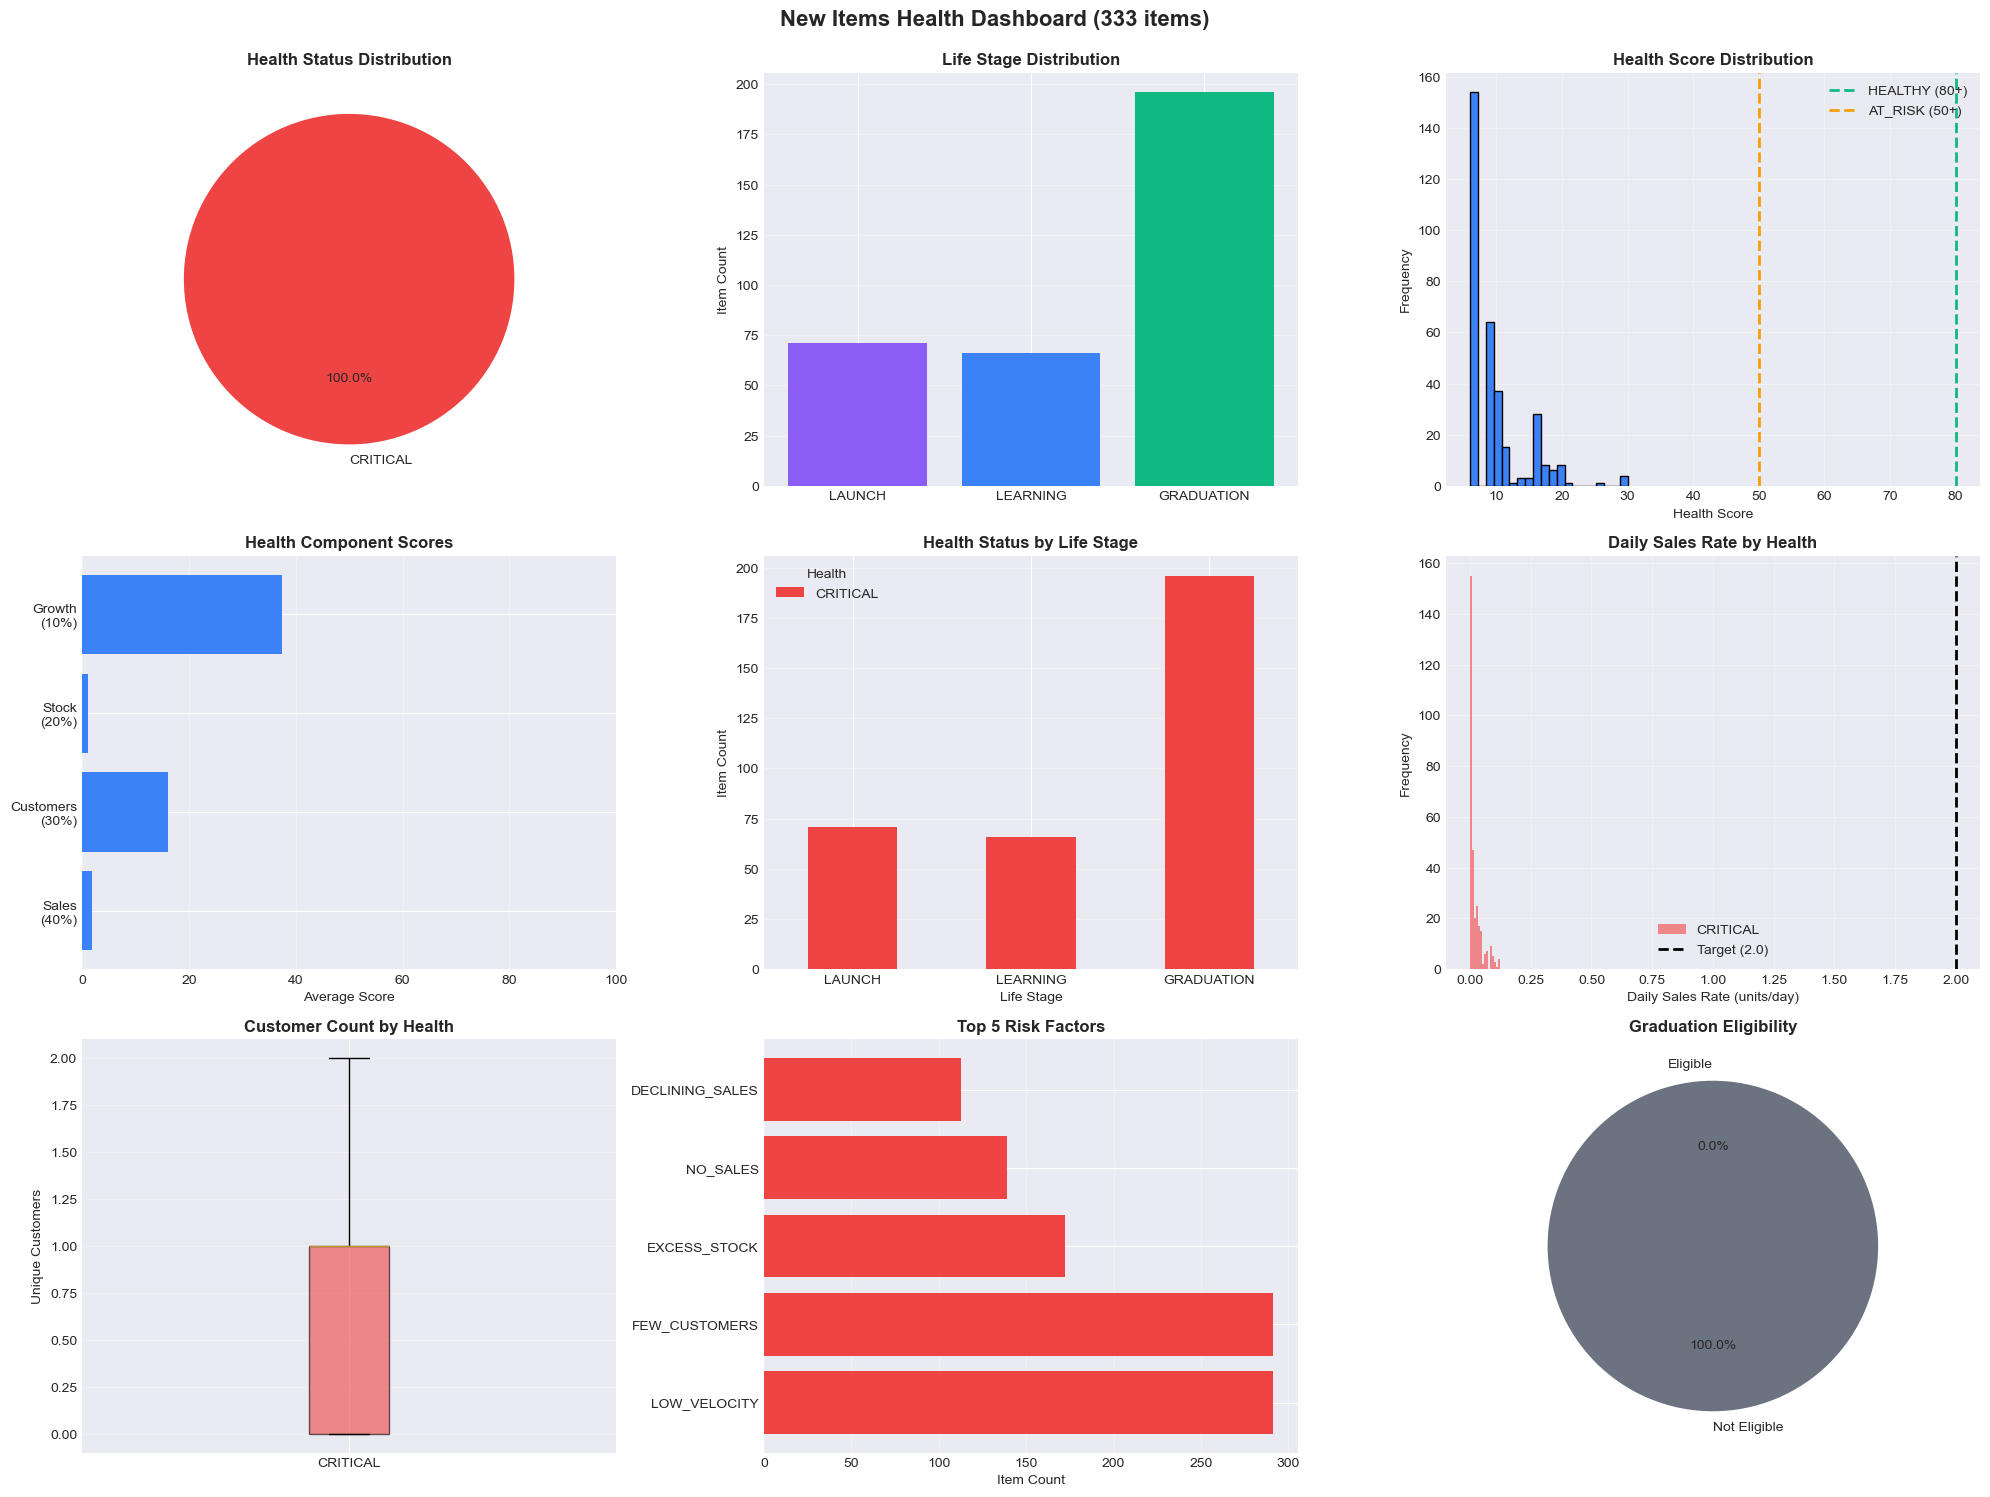


✅ Dashboard saved to /tmp/new_items_health_dashboard.png


In [12]:
if len(new_items) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    colors_health = {'HEALTHY': '#10B981', 'AT_RISK': '#F59E0B', 'CRITICAL': '#EF4444'}
    colors_stage = {'LAUNCH': '#8B5CF6', 'LEARNING': '#3B82F6', 'GRADUATION': '#10B981'}
    
    # 1. Health Status Distribution
    health_counts = new_items['health_status'].value_counts()
    colors_list = [colors_health[k] for k in health_counts.index]
    axes[0, 0].pie(health_counts.values, labels=health_counts.index, autopct='%1.1f%%',
                   colors=colors_list, startangle=90)
    axes[0, 0].set_title('Health Status Distribution', fontsize=12, fontweight='bold')
    
    # 2. Life Stage Distribution
    stage_counts = new_items['life_stage'].value_counts()
    stage_order = ['LAUNCH', 'LEARNING', 'GRADUATION']
    stage_counts = stage_counts.reindex(stage_order, fill_value=0)
    colors_list_stage = [colors_stage[k] for k in stage_counts.index]
    axes[0, 1].bar(range(len(stage_counts)), stage_counts.values, color=colors_list_stage)
    axes[0, 1].set_xticks(range(len(stage_counts)))
    axes[0, 1].set_xticklabels(stage_counts.index)
    axes[0, 1].set_ylabel('Item Count')
    axes[0, 1].set_title('Life Stage Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Health Score Distribution
    axes[0, 2].hist(new_items['health_score'], bins=20, color='#3B82F6', edgecolor='black')
    axes[0, 2].axvline(80, color='#10B981', linestyle='--', linewidth=2, label='HEALTHY (80+)')
    axes[0, 2].axvline(50, color='#F59E0B', linestyle='--', linewidth=2, label='AT_RISK (50+)')
    axes[0, 2].set_xlabel('Health Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Health Score Distribution', fontsize=12, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # 4. Component Scores Breakdown
    score_components = ['sales_performance_score', 'customer_acquisition_score', 
                       'stock_adequacy_score', 'growth_trend_score']
    component_means = [new_items[col].mean() for col in score_components]
    component_labels = ['Sales\n(40%)', 'Customers\n(30%)', 'Stock\n(20%)', 'Growth\n(10%)']
    
    axes[1, 0].barh(range(len(component_labels)), component_means, color='#3B82F6')
    axes[1, 0].set_yticks(range(len(component_labels)))
    axes[1, 0].set_yticklabels(component_labels)
    axes[1, 0].set_xlabel('Average Score')
    axes[1, 0].set_title('Health Component Scores', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlim(0, 100)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 5. Health by Life Stage
    stage_health = new_items.groupby(['life_stage', 'health_status']).size().unstack(fill_value=0)
    stage_health = stage_health.reindex(stage_order, fill_value=0)
    stage_health.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                     color=[colors_health.get(c, '#6B7280') for c in stage_health.columns])
    axes[1, 1].set_xlabel('Life Stage')
    axes[1, 1].set_ylabel('Item Count')
    axes[1, 1].set_title('Health Status by Life Stage', fontsize=12, fontweight='bold')
    axes[1, 1].legend(title='Health')
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # 6. Daily Sales Rate Distribution
    for status, color in colors_health.items():
        subset = new_items[new_items['health_status'] == status]['daily_sales_rate']
        if len(subset) > 0:
            axes[1, 2].hist(subset[subset < subset.quantile(0.95)], bins=15, alpha=0.6,
                          label=status, color=color)
    axes[1, 2].axvline(2.0, color='black', linestyle='--', linewidth=2, label='Target (2.0)')
    axes[1, 2].set_xlabel('Daily Sales Rate (units/day)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Daily Sales Rate by Health', fontsize=12, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    # 7. Customer Count Distribution
    health_order = ['HEALTHY', 'AT_RISK', 'CRITICAL']
    data_box_customers = [new_items[new_items['health_status'] == h]['unique_customers'].values 
                         for h in health_order if h in new_items['health_status'].values]
    labels_box = [h for h in health_order if h in new_items['health_status'].values]
    colors_box = [colors_health[h] for h in labels_box]
    
    bp = axes[2, 0].boxplot(data_box_customers, labels=labels_box, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[2, 0].set_ylabel('Unique Customers')
    axes[2, 0].set_title('Customer Count by Health', fontsize=12, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)
    
    # 8. Risk Factors Top 5
    if all_risks:
        risk_counts = pd.Series(all_risks).value_counts().head(5)
        axes[2, 1].barh(range(len(risk_counts)), risk_counts.values, color='#EF4444')
        axes[2, 1].set_yticks(range(len(risk_counts)))
        axes[2, 1].set_yticklabels(risk_counts.index)
        axes[2, 1].set_xlabel('Item Count')
        axes[2, 1].set_title('Top 5 Risk Factors', fontsize=12, fontweight='bold')
        axes[2, 1].grid(axis='x', alpha=0.3)
    else:
        axes[2, 1].text(0.5, 0.5, 'No Risk Factors', ha='center', va='center', fontsize=14)
        axes[2, 1].set_title('Top 5 Risk Factors', fontsize=12, fontweight='bold')
    
    # 9. Graduation Readiness
    grad_data = [
        new_items['graduation_eligible'].sum(),
        (~new_items['graduation_eligible']).sum()
    ]
    grad_labels = ['Eligible', 'Not Eligible']
    grad_colors = ['#10B981', '#6B7280']
    axes[2, 2].pie(grad_data, labels=grad_labels, autopct='%1.1f%%',
                  colors=grad_colors, startangle=90)
    axes[2, 2].set_title('Graduation Eligibility', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'New Items Health Dashboard ({len(new_items)} items)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('/tmp/new_items_health_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Dashboard saved to /tmp/new_items_health_dashboard.png")

## 1️⃣2️⃣ Save Results

In [13]:
if len(new_items) > 0:
    print("\n📤 SAVING HEALTH ANALYSIS RESULTS...\n")
    
    # 1. Complete health report
    new_items.to_csv('/tmp/new_items_health_report.csv', index=False)
    print(f"✅ /tmp/new_items_health_report.csv ({len(new_items)} items)")
    
    # 2. Pickle
    new_items.to_pickle('/tmp/new_items_health_report.pkl')
    print(f"✅ /tmp/new_items_health_report.pkl")
    
    # 3. At-risk items (MEDIUM + HIGH risk)
    at_risk = new_items[new_items['health_status'].isin(['AT_RISK', 'CRITICAL'])]
    if len(at_risk) > 0:
        at_risk.to_csv('/tmp/new_items_at_risk.csv', index=False)
        print(f"✅ /tmp/new_items_at_risk.csv ({len(at_risk)} items)")
    
    # 4. Healthy items
    healthy = new_items[new_items['health_status'] == 'HEALTHY']
    if len(healthy) > 0:
        healthy.to_csv('/tmp/new_items_healthy.csv', index=False)
        print(f"✅ /tmp/new_items_healthy.csv ({len(healthy)} items)")
    
    # 5. Critical items
    critical = new_items[new_items['health_status'] == 'CRITICAL']
    if len(critical) > 0:
        critical.to_csv('/tmp/new_items_critical.csv', index=False)
        print(f"✅ /tmp/new_items_critical.csv ({len(critical)} items)")
    
    # 6. Summary report
    summary_data = {
        'Metric': [
            'Total New Items',
            'Avg Health Score',
            'HEALTHY Count',
            'AT_RISK Count',
            'CRITICAL Count',
            'LAUNCH Stage',
            'LEARNING Stage',
            'GRADUATION Stage',
            'Graduation Eligible',
            'Items with No Risks',
            'Avg Daily Sales Rate',
            'Avg Customers',
            'Avg Days of Stock',
            'Total Stock Value'
        ],
        'Value': [
            len(new_items),
            f"{new_items['health_score'].mean():.1f}",
            (new_items['health_status'] == 'HEALTHY').sum(),
            (new_items['health_status'] == 'AT_RISK').sum(),
            (new_items['health_status'] == 'CRITICAL').sum(),
            (new_items['life_stage'] == 'LAUNCH').sum(),
            (new_items['life_stage'] == 'LEARNING').sum(),
            (new_items['life_stage'] == 'GRADUATION').sum(),
            new_items['graduation_eligible'].sum(),
            (new_items['risk_factors'] == 'NONE').sum(),
            f"{new_items['daily_sales_rate'].mean():.2f}",
            f"{new_items['unique_customers'].mean():.1f}",
            f"{new_items['days_of_stock'].mean():.1f}",
            f"₹{new_items['stock_value'].sum():,.0f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('/tmp/new_items_summary.csv', index=False)
    print(f"✅ /tmp/new_items_summary.csv")
    
    print("\n" + "="*100)
    print("✅ ALL FILES SAVED SUCCESSFULLY")
    print("="*100)
    
    print("\n📊 SUMMARY:")
    print(summary_df.to_string(index=False))

else:
    print("\n⚠️ No output files created (no new items found)")


📤 SAVING HEALTH ANALYSIS RESULTS...

✅ /tmp/new_items_health_report.csv (333 items)
✅ /tmp/new_items_health_report.pkl
✅ /tmp/new_items_at_risk.csv (333 items)
✅ /tmp/new_items_critical.csv (333 items)
✅ /tmp/new_items_summary.csv

✅ ALL FILES SAVED SUCCESSFULLY

📊 SUMMARY:
              Metric   Value
     Total New Items     333
    Avg Health Score     9.6
       HEALTHY Count       0
       AT_RISK Count       0
      CRITICAL Count     333
        LAUNCH Stage      71
      LEARNING Stage      66
    GRADUATION Stage     196
 Graduation Eligible       0
 Items with No Risks      23
Avg Daily Sales Rate    0.03
       Avg Customers     0.5
   Avg Days of Stock   517.8
   Total Stock Value ₹64,672


## ✅ Summary

### Health Assessment Complete!

### Files Created:
1. **`new_items_health_report.csv`** ⭐ (Complete analysis with scores)
2. **`new_items_health_report.pkl`** (Faster loading)
3. **`new_items_at_risk.csv`** (Items needing attention)
4. **`new_items_healthy.csv`** (Performing well)
5. **`new_items_critical.csv`** (Urgent action required)
6. **`new_items_summary.csv`** (Executive summary)
7. **`new_items_health_dashboard.png`** (9 visualizations)

### New Columns Added:
- **life_stage**: LAUNCH / LEARNING / GRADUATION
- **days_in_stage**: Days in current stage
- **daily_sales_rate**: Units sold per day
- **sales_performance_score**: 0-100 (40% weight)
- **customer_acquisition_score**: 0-100 (30% weight)
- **stock_adequacy_score**: 0-100 (20% weight)
- **growth_trend_score**: 0-100 (10% weight)
- **health_score**: 0-100 (weighted total)
- **health_status**: HEALTHY / AT_RISK / CRITICAL
- **risk_factors**: Comma-separated list
- **recommendation**: Actionable advice
- **recommendation_type**: Category of recommendation
- **graduation_eligible**: Boolean
- **criteria_met**: Number of criteria passed (0-6)
- **criteria_passed**: Which criteria passed

### Next Steps:
Run **Notebook 4** to analyze demand patterns and calculate order quantities for ACTIVE items (FAST + SLOW)